In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 内容のまとめ

In [2]:
N = 10000
x, A = np.random.rand(N), np.random.rand(N,N)
A[A>1/N] = 0 # 行列Aのうち，1/N以上の要素を零としている
A@x          # 通常の行列ベクトル積演算

array([5.99202035e-06, 6.19827033e-05, 0.00000000e+00, ...,
       0.00000000e+00, 1.65763771e-04, 0.00000000e+00])

In [3]:
from scipy.sparse import csr_matrix
A_csr = csr_matrix(A) # ndarray形式の密行列から疎行列を生成
A_csr*x               # 疎行列と密ベクトルの積を計算
                      # 行列ベクトル積が@でなく*である点に注意

array([5.99202035e-06, 6.19827033e-05, 0.00000000e+00, ...,
       0.00000000e+00, 1.65763771e-04, 0.00000000e+00])

In [4]:
from scipy.sparse import coo_matrix
data = [1., 2., 3., 4., 5.]
row = [0, 0, 1, 2, 2]
col = [2, 3, 3, 2, 4]
A_coo = coo_matrix((data, (row, col)), shape=(5, 5))
A_csr = csr_matrix(A_coo) # A_coo.tocsr()としてもよい

In [5]:
print(A_csr.toarray())

[[0. 0. 1. 2. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 4. 0. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [6]:
from scipy.sparse import linalg, diags
A_csr = diags(np.ones(10), format="csr")
  # ベクトルから対角成分のみの疎行列を生成する
A_csr.shape # numpy.ndarrayと同様，(行,列)の次元を返す
eig, vec = linalg.eigs(A_csr, k=2)
  # 疎行列に対する線形代数演算はscipy.sparse.linalgで行う.
  # eigsは一般行列の最大値からk個までの固有値を求める関数

# 例題11 線形連立方程式

In [7]:
A, b = np.random.rand(3000, 3000), np.random.rand(3000, 100)

In [8]:
%%timeit
x = np.dot(np.linalg.inv(A),b)

4.09 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# テキストには含まれない
%%timeit
x = np.linalg.solve(A, b)

1.05 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 例題11の発展問題

In [10]:
def user_lu(A):
    L, U = np.eye(len(A)), np.zeros_like(A)
    for j in range(len(A)):
        for i in range(j+1):
            U[i,j] = A[i,j]-L[i,:j]@U[:j,j]
        L[j+1:,j] = (A[j+1:,j]-L[j+1:,:j]@U[:j,j])/U[j,j]
    return L, U

In [11]:
A = np.random.rand(1000,1000)
L, U = user_lu(A)
print(np.linalg.norm(A-L@U))

7.340806460557764e-09


In [12]:
import scipy.linalg
P, L, U = scipy.linalg.lu(A)
print(np.linalg.norm(A-P@L@U))

7.327118909863642e-13


In [13]:
# テキストには含まれない
from time import time
time_s = time()
L, U = user_lu(A)
print(time()-time_s)
time_s = time()
P, L, U = scipy.linalg.lu(A)
print(time()-time_s)

5.260680437088013
0.0476834774017334


# 例題12 量子ハイゼンベルグ模型の対角化I

In [14]:
A = np.array([[1,0,0,0], [0,-1,2,0], [0,2,-1,0], [0,0,0,1]])/4
eig, vec = np.linalg.eigh(A)

# 例題13 量子ハイゼンベルグ模型の対角化II

In [15]:
a = 0b11 # 0bをつけると2進数表記を表す. つまりa=3 と同じ
a & 0b01 # & はビットごとのand を表す. 結果は0b01
a | 0b01 # | はビットごとのor を表す. 結果は0b11
a ^ 0b01 # ^ はビットごとのxor を表す. 結果は0b10

2

In [16]:
def HMatrix(ns, bl):
    dim = 2**ns
    H = np.zeros([dim, dim])
    ind = np.arange(dim) # スピン状態を表す配列
    for bond in bl:      # それぞれのbondに対して計算する
        bs = ind & bond
        ind1 = (bs != 0) & (bs != bond)
        # 各状態に対しボンド上の2スピンが異符号ならTrueとなる配列
        H[ind,ind] += 1 - 2*ind1  # 対角要素に +1 or -1
        ind2 = ind[ind1]
        # ボンド上の2スピンが異符号の状態を抜き出した配列
        H[ind2^bond, ind2] += 2  # 非対角要素
    return H/4

In [17]:
H = HMatrix(3, [0b011, 0b110, 0b101]) # リストは[3,6,5]でも同じ
eig, vec = np.linalg.eigh(H)
print(eig)

[-0.75 -0.75 -0.75 -0.75  0.75  0.75  0.75  0.75]


In [18]:
N = 5
bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
  # << はビットシフト演算子. 周期的にならないので, 補正を加えている

# 例題14 量子ハイゼンベルグ模型の対角化III

In [19]:
from scipy.sparse import csr_matrix, linalg
H_csr = csr_matrix(H)
eig, vec = linalg.eigsh(H_csr, 3, which='SA')
  # whichは計算する固有値の指定. SAは値が小さいものから計算
  # LAは値の大きいもの, SM,LMはそれぞれ絶対値の小さい,大きいもの
  # から順に計算してk(=3)個出力する 

In [20]:
def multiplyH(v, bl):
    bl = np.array(bl)
    vind = np.arange(len(v))    # スピン状態を表す配列
    vn = np.zeros_like(v)       # vと同じ形状で値が0の行列
    for bond in bl:
        bs = vind & bond
        ind1 = (bs != 0) & (bs != bond)
        vn[vind] += v[vind] * (1-2*ind1)   # 対角項
        ind2 = vind[ind1]
        vn[ind2 ^ bond] += v[ind2] * 2     # 非対角項
    return vn/4

In [21]:
N = 16
H = lambda v : multiplyH(v, bl)
op = linalg.LinearOperator(shape=(2**N, 2**N), matvec=H)
 # shapeで行列の次元を指定. matvacは行列ベクトル積Axの作用を指定
 # 問題によってはA^Hxや行列行列積ARなどが必要となり, それぞれ
 # rmatvecとmatmatで指定する
eig, vec = linalg.eigsh(op, k=3, which='SA')

# 例題14の発展問題

In [22]:
from scipy.sparse import csr_matrix, coo_matrix, linalg
def HMatrix_data(ns, bl, ind):
    data = np.empty(0)
    row, col = np.empty(0,dtype=int), np.empty(0,dtype=int)
    for bond in bl:
        bs = ind & bond
        ind1 = (bs != 0) & (bs != bond)
        ind2 = ind[ind1]
        unit = np.ones(len(ind2))
        data = np.append(data, np.append(1-2*ind1, 2*unit))
        row = np.append(row, np.append(ind, ind2^bond))
        col = np.append(col, np.append(ind, ind2))
    return data/4, row, col

In [23]:
N = 15
bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
nsz = [bin(i).count("1") for i in np.arange(2**N)]
map_ind = np.zeros(2**N, dtype=int)
for n in np.arange(N+1):
    ind = np.where(nsz==n)[0]
    map_ind[ind] = np.arange(len(ind))
    data, row, col = HMatrix_data(N, bl, ind)
    row, col = map_ind[row], map_ind[col]
    A_coo=coo_matrix((data,(row,col)), (len(ind),len(ind)))
    A_csr=csr_matrix(A_coo)
    if n==0 or n==N: eig = [A_csr[0,0]]
    else: eig, vec = linalg.eigsh(A_csr, k=2, which='SA')
    print(n, eig)

0 [3.75]
1 [1.7718524 1.7718524]
2 [-0.1571693 -0.1571693]
3 [-1.97564535 -1.97564535]
4 [-3.61000831 -3.61000831]
5 [-4.97597881 -4.97597881]
6 [-5.98180389 -5.98180389]
7 [-6.53366757 -6.53366757]
8 [-6.53366757 -6.53366757]
9 [-5.98180389 -5.98180389]
10 [-4.97597881 -4.97597881]
11 [-3.61000831 -3.61000831]
12 [-1.97564535 -1.97564535]
13 [-0.1571693 -0.1571693]
14 [1.7718524 1.7718524]
15 [3.75]


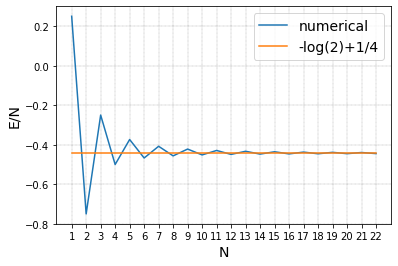

In [24]:
# テキスト中には含まれない
Ns, ans = np.arange(1,23), []
for N in Ns:
    bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
    nsz = [bin(i).count("1") for i in np.arange(2**N)]
    map = np.zeros(2**N, dtype=int)
    for n in np.arange(N+1):
        if n!=N//2: continue
        ind = np.where(nsz==n)[0]
        map[ind] = np.arange(len(ind))

        data, row, col = HMatrix_data(N, bl, ind)
        row, col = map[row], map[col]
        A_coo = coo_matrix((data, (row, col)), shape=(len(ind), len(ind)))
        A_csr = csr_matrix(A_coo)
        if N==1 : eig = [A_csr[0,0]]
        else    : eig, vec = linalg.eigsh(A_csr, k=1, which="SA")
        ans.append(eig[0]/N)
plt.plot(Ns, np.array(ans), label="numerical")
plt.plot(Ns, -np.log(2)*np.ones_like(Ns)+0.25, label="-log(2)+1/4")
plt.xlabel("N", fontsize=14)
plt.xticks(Ns)
plt.ylabel("E/N", fontsize=14)
plt.legend(fontsize=14)
plt.grid(color="black", linestyle="dotted", linewidth=0.3)
plt.show()